In [1]:
from keras.applications import VGG16


c:\users\gene\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights = 'imagenet', include_top=False, input_shape = (150, 150, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/Gene/Desktop/projects/keras_tutorial/datasets/dogs_cats'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20


In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size= batch_size, class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1)* batch_size] = features_batch
        labels[i * batch_size : (i+1)* batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features,(2000, 4*4*512))
validation_features = np.reshape(validation_features,(1000, 4*4*512))
test_features = np.reshape(test_features,(1000, 4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = 'binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs = 30, batch_size = 20, validation_data = (validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 674us/step - loss: 0.6088 - acc: 0.6615 - val_loss: 0.4502 - val_acc: 0.8310
Epoch 2/30
2000/2000 [==============================] - 1s 321us/step - loss: 0.4315 - acc: 0.8145 - val_loss: 0.3708 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.3675 - acc: 0.8435 - val_loss: 0.3277 - val_acc: 0.8810
Epoch 4/30
2000/2000 [==============================] - 1s 328us/step - loss: 0.3310 - acc: 0.8565 - val_loss: 0.3000 - val_acc: 0.8910
Epoch 5/30
2000/2000 [==============================] - 1s 326us/step - loss: 0.2874 - acc: 0.8855 - val_loss: 0.2832 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 321us/step - loss: 0.2647 - acc: 0.8965 - val_loss: 0.2686 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 1s 352us/step - loss: 0.2510 - acc: 0.9050 - val_loss: 0.2617 - val_acc: 0.8960


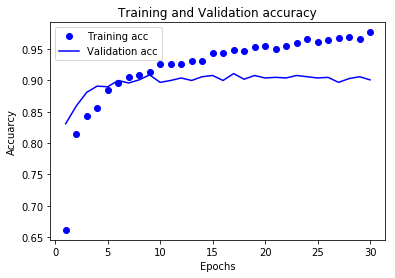

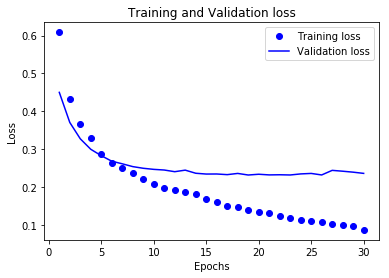

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuarcy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


### 결과해석
1. 정확도는 약 90% // validation test set
2. Dropout 방법을 사용했음에도 훈련을 시작하자마자 바로 과대적합 문제발생 중 -> 작은 데이터셋으로부터 나오는 문제라고 볼 수 있다.
3. 적은 데이터로 발생하는 과대적합을 막기 위해서는 Data Augumentation을 진행하여 더 많은 데이터셋을 만들어 내야한다.

## Data Augumentation Application

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range = 0.2, zoom_range=0.2, horizontal_flip = True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale =1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 20, class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size = (150, 150), batch_size = 20, class_mode = 'binary')


model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50, verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 24s - loss: 0.4142 - acc: 0.8110 - val_loss: 0.1636 - val_acc: 0.9310
Epoch 2/30
 - 20s - loss: 0.2677 - acc: 0.8890 - val_loss: 0.1891 - val_acc: 0.9240
Epoch 3/30
 - 20s - loss: 0.2057 - acc: 0.9150 - val_loss: 0.0994 - val_acc: 0.9590
Epoch 4/30
 - 20s - loss: 0.1655 - acc: 0.9310 - val_loss: 0.2205 - val_acc: 0.9290
Epoch 5/30
 - 20s - loss: 0.1570 - acc: 0.9335 - val_loss: 0.0923 - val_acc: 0.9640
Epoch 6/30
 - 20s - loss: 0.1209 - acc: 0.9520 - val_loss: 0.0894 - val_acc: 0.9670
Epoch 7/30
 - 20s - loss: 0.1113 - acc: 0.9605 - val_loss: 0.0852 - val_acc: 0.9630
Epoch 8/30
 - 20s - loss: 0.1075 - acc: 0.9545 - val_loss: 0.1416 - val_acc: 0.9440
Epoch 9/30
 - 20s - loss: 0.0949 - acc: 0.9605 - val_loss: 0.0874 - val_acc: 0.9680
Epoch 10/30
 - 20s - loss: 0.0964 - acc: 0.9625 - val_loss: 0.2435 - val_acc: 0.9240
Epoch 11/30
 - 20s - loss: 0.0740 - acc: 0.9720 - val_loss: 0.0662 - val_ac

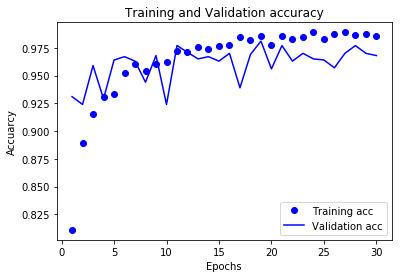

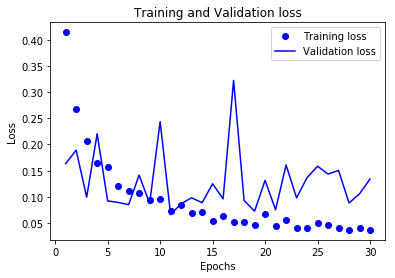

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuarcy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 결과해석
1. 검증 정확도가 높아졌다.
2. 손실값 또한 처음 훈련시킨 컨브넷보다 과대적합이 줄었음을 알 수 있다.

# 미세조정
1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크 추가
2. 기반 네트워크 동결
3. 새로 추가한 네트워크 학습
4. 기반 네트워크 중 일부 동결 해제
5. 동결 해제층과 함께 학습 진행.

일반적으로는 최상위 2~3층만 미세조정 하는 것이 좋다.

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(loss = 'binary_crossentropy', optimizer= optimizers.RMSprop(lr=1e-5), metrics = ['acc'])
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data = validation_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 19s 192ms/step - loss: 0.0179 - acc: 0.9925 - val_loss: 0.1178 - val_acc: 0.9810
Epoch 2/100
100/100 [==============================] - 15s 150ms/step - loss: 0.0142 - acc: 0.9950 - val_loss: 0.1244 - val_acc: 0.9770
Epoch 3/100
100/100 [==============================] - 15s 150ms/step - loss: 0.0164 - acc: 0.9945 - val_loss: 0.0810 - val_acc: 0.9830
Epoch 4/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0122 - acc: 0.9940 - val_loss: 0.1060 - val_acc: 0.9780
Epoch 5/100
100/100 [==============================] - 15s 154ms/step - loss: 0.0134 - acc: 0.9955 - val_loss: 0.1308 - val_acc: 0.9800
Epoch 6/100
100/100 [==============================] - 15s 151ms/step - loss: 0.0074 - acc: 0.9970 - val_loss: 0.1164 - val_acc: 0.9810
Epoch 7/100
100/100 [==============================] - 15s 154ms/step - loss: 0.0098 - acc: 0.9960 - val_loss: 0.1061 - val_acc: 0.9810
Epoch 8/100
100/100 [===========================

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuarcy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc))

plt.plot(epochs, smooth_curve(acc), 'bo', label = "Smoothed Training acc")
plt.plot(epochs, smooth_curve(val_acc), 'b', label = "Smoothed Validation acc")
plt.title("Smoothed Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuarcy")
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label = "Smoothed Training loss")
plt.plot(epochs, smooth_curve(val_loss), 'b', label = "Smoothed Validation loss")
plt.title("Smoothed Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 20, class_mode = 'binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test_acc : ', test_acc)